# Preprocesamiento de Datos Genéticos para Alzheimer

Este cuaderno implementa el preprocesamiento de datos genéticos para el proyecto de Monitorización Multimodal de Alzheimer, enfocándose en:
1. Carga y limpieza inicial de datos,
2. Tratamiento de valores atípicos,
3. Imputación de valores faltantes,
4. Transformaciones de variables,
5. Normalización de datos,
6. Generación de características adicionales,
7. Integración de datos APOE y Tau,
8. Exportación de datos preprocesados

Trabajaremos con los datasets:
- APOERES.csv: Información de genotipos APOE,
- JANSSEN_PLASMA_P217_TAU.csv: Información de biomarcadores Tau

***

## 1. Importación de librerías necesarias

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('ggplot')

## 2. Carga de datos

In [14]:
print("Cargando datasets genéticos...")

# Cargar los datasets
apoe_data = pd.read_csv('../data/raw/adni/genetics/APOERES.csv')
tau_data = pd.read_csv('../data/raw/adni/genetics/JANSSEN_PLASMA_P217_TAU.csv')

print(f"APOE Dataset: {apoe_data.shape[0]} filas y {apoe_data.shape[1]} columnas")
print(f"TAU Dataset: {tau_data.shape[0]} filas y {tau_data.shape[1]} columnas")

# Verificar columnas
print("\nColumnas en APOE Dataset:")
print(apoe_data.columns.tolist())
print("\nColumnas en TAU Dataset:")
print(tau_data.columns.tolist())

# Mostrar primeras filas
print("\nPrimeras filas de APOE Dataset:")
display(apoe_data.head())
print("\nPrimeras filas de TAU Dataset:")
display(tau_data.head())

Cargando datasets genéticos...
APOE Dataset: 2760 filas y 16 columnas
TAU Dataset: 130 filas y 9 columnas

Columnas en APOE Dataset:
['PHASE', 'PTID', 'RID', 'VISCODE', 'GENOTYPE', 'APTESTDT', 'APVOLUME', 'APRECEIVE', 'APAMBTEMP', 'APRESAMP', 'APUSABLE', 'ID', 'SITEID', 'USERDATE', 'USERDATE2', 'update_stamp']

Columnas en TAU Dataset:
['PTID', 'RID', 'EXAMDATE', 'VISCODE2', 'RUN', 'SAMPLE_ID', 'DILUTION_CORRECTED_CONC', 'CV', 'update_stamp']

Primeras filas de APOE Dataset:


,PHASE,PTID,RID,VISCODE,GENOTYPE,APTESTDT,APVOLUME,APRECEIVE,APAMBTEMP,APRESAMP,APUSABLE,ID,SITEID,USERDATE,USERDATE2,update_stamp
0,ADNI1,011_S_0002,2,sc,3/3,2005-08-22,5.0,1.0,1.0,0.0,1.0,4.0,107.0,2005-08-23,NaN,2005-08-23 00:00:00.0
1,ADNI1,011_S_0003,3,sc,3/4,2005-08-22,10.0,1.0,1.0,0.0,1.0,6.0,107.0,2005-08-23,NaN,2005-08-23 00:00:00.0
2,ADNI1,022_S_0004,4,sc,3/3,2005-08-22,9.2,1.0,1.0,0.0,1.0,8.0,10.0,2005-08-23,NaN,2005-08-23 00:00:00.0
3,ADNI1,011_S_0005,5,sc,3/3,2005-08-29,10.0,1.0,1.0,0.0,1.0,10.0,107.0,2005-08-29,NaN,2005-08-29 00:00:00.0
4,ADNI1,022_S_0007,7,sc,3/4,2005-09-05,9.0,1.0,1.0,0.0,1.0,12.0,10.0,2005-09-06,NaN,2005-09-06 00:00:00.0



Primeras filas de TAU Dataset:


,PTID,RID,EXAMDATE,VISCODE2,RUN,SAMPLE_ID,DILUTION_CORRECTED_CONC,CV,update_stamp
0,128_S_0138,138,2016-02-18,m120,1,GA80GN4N-09,0.140,4%,2024-01-25 20:11:34.0
1,126_S_1187,1187,2016-01-27,m108,1,HA80GLG5-08,0.133,4%,2024-01-25 20:11:34.0
2,023_S_0031,31,2016-01-27,m120,1,AA80GLLT-09,0.081,1%,2024-01-25 20:11:34.0
3,018_S_4399,4399,2016-01-07,m48,1,JA80GLZ1-09,0.055,9%,2024-01-25 20:11:34.0
4,033_S_4176,4176,2016-01-06,m48,1,CA80GLWP-10,0.200,2%,2024-01-25 20:11:34.0


In [15]:
apoe_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2760 entries, 0 to 2759
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PHASE         2760 non-null   object 
 1   PTID          2760 non-null   object 
 2   RID           2760 non-null   int64  
 3   VISCODE       1159 non-null   object 
 4   GENOTYPE      2760 non-null   object 
 5   APTESTDT      1159 non-null   object 
 6   APVOLUME      1159 non-null   float64
 7   APRECEIVE     1159 non-null   float64
 8   APAMBTEMP     1159 non-null   float64
 9   APRESAMP      1159 non-null   float64
 10  APUSABLE      1159 non-null   float64
 11  ID            1159 non-null   float64
 12  SITEID        1159 non-null   float64
 13  USERDATE      1159 non-null   object 
 14  USERDATE2     0 non-null      float64
 15  update_stamp  2760 non-null   object 
dtypes: float64(8), int64(1), object(7)
memory usage: 345.1+ KB


## 3. Exploración básica y análisis de valores faltantes

In [16]:
def analizar_nulos(df, nombre):
    """Función para analizar valores nulos en un dataframe"""
    nulos = df.isnull().sum()
    porcentaje_nulos = (nulos / len(df)) * 100
    
    info_nulos = pd.DataFrame({
        'Valores Nulos': nulos,
        'Porcentaje (%)': porcentaje_nulos.round(2)
    }).sort_values('Valores Nulos', ascending=False)
    
    print(f"\nAnálisis de valores nulos en {nombre}:")
    display(info_nulos[info_nulos['Valores Nulos'] > 0])
    return info_nulos

# Análisis de nulos en ambos datasets
nulos_apoe = analizar_nulos(apoe_data, "APOE Dataset")
nulos_tau = analizar_nulos(tau_data, "TAU Dataset")
'APVOLUME', 'APRECEIVE', 'APAMBTEMP', 'APRESAMP'


Análisis de valores nulos en APOE Dataset:


,Valores Nulos,Porcentaje (%)
USERDATE2,2760,100.00
VISCODE,1601,58.01
APTESTDT,1601,58.01
APVOLUME,1601,58.01
APRECEIVE,1601,58.01
APAMBTEMP,1601,58.01
APRESAMP,1601,58.01
APUSABLE,1601,58.01
ID,1601,58.01
SITEID,1601,58.01



Análisis de valores nulos en TAU Dataset:


,Valores Nulos,Porcentaje (%)
CV,2,1.54


('APVOLUME', 'APRECEIVE', 'APAMBTEMP', 'APRESAMP')

## 4. Preprocesamiento de APOE Dataset

In [17]:
print("\n=== Preprocesamiento del Dataset APOE ===")

# 4.1 Copia del dataset original para preservar los datos
apoe_proc = apoe_data.copy()

# 4.2 Convertir fechas a formato datetime
date_columns = ['APTESTDT', 'USERDATE', 'USERDATE2', 'update_stamp']
for col in date_columns:
    if col in apoe_proc.columns:
        apoe_proc[col] = pd.to_datetime(apoe_proc[col], errors='coerce')
        
        # Extraer características de fechas
        if not apoe_proc[col].isna().all():
            apoe_proc[f'{col}_year'] = apoe_proc[col].dt.year
            apoe_proc[f'{col}_month'] = apoe_proc[col].dt.month
            apoe_proc[f'{col}_day'] = apoe_proc[col].dt.day

# 4.3 Imputación de valores faltantes en variables categóricas
categorical_cols = ['PHASE', 'GENOTYPE', 'APUSABLE']
for col in categorical_cols:
    if col in apoe_proc.columns and apoe_proc[col].isna().any():
        # Usar la moda para imputar valores faltantes en variables categóricas
        modo = apoe_proc[col].mode()[0]
        apoe_proc[col] = apoe_proc[col].fillna(modo)
        print(f"Imputados valores faltantes en {col} con la moda: {modo}")

# 4.4 Imputación de valores numéricos
numerical_cols = ['APVOLUME', 'APRECEIVE', 'APAMBTEMP', 'APRESAMP']
for col in numerical_cols:
    if col in apoe_proc.columns and apoe_proc[col].isna().any():
        # Imputar con la mediana
        mediana = apoe_proc[col].median()
        apoe_proc[col] = apoe_proc[col].fillna(mediana)
        print(f"Imputados valores faltantes en {col} con la mediana: {mediana:.2f}")

# 4.5 Crear variables dummy para genotipo APOE
if 'GENOTYPE' in apoe_proc.columns:
    # Crear dummies para genotipos
    genotype_dummies = pd.get_dummies(apoe_proc['GENOTYPE'], prefix='GENOTYPE')
    apoe_proc = pd.concat([apoe_proc, genotype_dummies], axis=1)
    
    # Crear flag para presencia de alelo e4 (factor de riesgo para Alzheimer)
    apoe_proc['APOE_e4_present'] = apoe_proc['GENOTYPE'].apply(
        lambda x: 1 if '4' in str(x) else 0)
    
    print(f"Creadas variables dummy para GENOTYPE y flag para presencia de alelo e4")

# 4.6 Verificar y mostrar resultados del preprocesamiento
print("\nDimensiones del dataset APOE después del preprocesamiento:", apoe_proc.shape)
print("Nuevas columnas añadidas:")
nuevas_columnas = set(apoe_proc.columns) - set(apoe_data.columns)
print(sorted(nuevas_columnas))


=== Preprocesamiento del Dataset APOE ===
Imputados valores faltantes en APUSABLE con la moda: 1.0
Imputados valores faltantes en APVOLUME con la mediana: 9.00
Imputados valores faltantes en APRECEIVE con la mediana: 1.00
Imputados valores faltantes en APAMBTEMP con la mediana: 1.00
Imputados valores faltantes en APRESAMP con la mediana: 0.00
Creadas variables dummy para GENOTYPE y flag para presencia de alelo e4

Dimensiones del dataset APOE después del preprocesamiento: (2760, 32)
Nuevas columnas añadidas:
['APOE_e4_present', 'APTESTDT_day', 'APTESTDT_month', 'APTESTDT_year', 'GENOTYPE_2/2', 'GENOTYPE_2/3', 'GENOTYPE_2/4', 'GENOTYPE_3/3', 'GENOTYPE_3/4', 'GENOTYPE_4/4', 'USERDATE_day', 'USERDATE_month', 'USERDATE_year', 'update_stamp_day', 'update_stamp_month', 'update_stamp_year']


## 5. Preprocesamiento de TAU Dataset

In [18]:
print("\n=== Preprocesamiento del Dataset TAU ===")

# 5.1 Copia del dataset original para preservar los datos
tau_proc = tau_data.copy()

# 5.2 Convertir EXAMDATE a datetime
if 'EXAMDATE' in tau_proc.columns:
    tau_proc['EXAMDATE'] = pd.to_datetime(tau_proc['EXAMDATE'], errors='coerce')
    
    # Extraer características de fecha
    tau_proc['EXAMDATE_year'] = tau_proc['EXAMDATE'].dt.year
    tau_proc['EXAMDATE_month'] = tau_proc['EXAMDATE'].dt.month
    tau_proc['EXAMDATE_day'] = tau_proc['EXAMDATE'].dt.day

# 5.3 Detección y tratamiento de valores atípicos (outliers) en la concentración de Tau
if 'DILUTION_CORRECTED_CONC' in tau_proc.columns:
    # Almacenar valores originales
    tau_proc['DILUTION_CORRECTED_CONC_original'] = tau_proc['DILUTION_CORRECTED_CONC']
    
    # Calcular estadísticas para detección de outliers
    Q1 = tau_proc['DILUTION_CORRECTED_CONC'].quantile(0.25)
    Q3 = tau_proc['DILUTION_CORRECTED_CONC'].quantile(0.75)
    IQR = Q3 - Q1
    
    # Límites para considerar outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identificar outliers
    outliers = tau_proc[(tau_proc['DILUTION_CORRECTED_CONC'] < lower_bound) | 
                         (tau_proc['DILUTION_CORRECTED_CONC'] > upper_bound)]
    
    print(f"Identificados {len(outliers)} outliers en DILUTION_CORRECTED_CONC")
    print(f"Límite inferior: {lower_bound:.4f}, Límite superior: {upper_bound:.4f}")
    
    # Winsorización: reemplazar outliers por los percentiles 5 y 95
    p05 = tau_proc['DILUTION_CORRECTED_CONC'].quantile(0.05)
    p95 = tau_proc['DILUTION_CORRECTED_CONC'].quantile(0.95)
    
    tau_proc['DILUTION_CORRECTED_CONC_winsorized'] = tau_proc['DILUTION_CORRECTED_CONC'].copy()
    tau_proc.loc[tau_proc['DILUTION_CORRECTED_CONC'] < lower_bound, 'DILUTION_CORRECTED_CONC_winsorized'] = p05
    tau_proc.loc[tau_proc['DILUTION_CORRECTED_CONC'] > upper_bound, 'DILUTION_CORRECTED_CONC_winsorized'] = p95
    
    # Transformación logarítmica para normalizar la distribución
    epsilon = 1e-10  # Valor pequeño para evitar log(0)
    tau_proc['DILUTION_CORRECTED_CONC_log'] = np.log1p(tau_proc['DILUTION_CORRECTED_CONC_winsorized'] + epsilon)
    
    print("Aplicada winsorización y transformación logarítmica a DILUTION_CORRECTED_CONC")

# 5.4 Imputación de valores faltantes en CV usando KNN
if 'CV' in tau_proc.columns and tau_proc['CV'].isna().any():
    # Asegurar que CV y otras columnas estén en formato numérico
    # aquí 'cv' viene con '%', lo eliminamos y lo convertimos a float
    tau_proc['CV'] = (
        tau_proc['CV']
          .astype(str)
          .str.rstrip('%')         # elimina el símbolo '%'
          .replace('', np.nan)     # en caso de strings vacíos
          .astype(float) / 100.0   # pasarlo a proporción (0.04 en lugar de 4.0)
    )

    # Preparar lista de features numéricas
    numerical_features = ['DILUTION_CORRECTED_CONC', 'EXAMDATE_year', 'CV']

    # Convertirlas a numérico por si hubiera algún otro string
    for col in numerical_features:
        tau_proc[col] = pd.to_numeric(tau_proc[col], errors='coerce')

    # Imputar con KNN
    imputer = KNNImputer(n_neighbors=5)
    imputation_data = tau_proc[numerical_features].copy()
    imputed_values = imputer.fit_transform(imputation_data)
    imputed_df = pd.DataFrame(
        imputed_values,
        columns=numerical_features,
        index=tau_proc.index
    )

    # Sólo reemplazar CV donde era NaN
    mask_cv_na = tau_proc['CV'].isna()
    tau_proc.loc[mask_cv_na, 'CV'] = imputed_df.loc[mask_cv_na, 'CV']
    print(f"Imputados {mask_cv_na.sum()} valores faltantes en CV usando KNN")

# 5.5 Normalización de variables numéricas
numerical_features_tau = ['DILUTION_CORRECTED_CONC_winsorized', 'DILUTION_CORRECTED_CONC_log', 'CV']
scaler = MinMaxScaler()

# Normalización estándar (Min-Max)
for col in numerical_features_tau:
    if col in tau_proc.columns and not tau_proc[col].isna().all():
        tau_proc[f'{col}_normalized'] = scaler.fit_transform(tau_proc[[col]])
        print(f"Normalizada la variable {col}")

# 5.6 Verificar y mostrar resultados del preprocesamiento
print("\nDimensiones del dataset TAU después del preprocesamiento:", tau_proc.shape)
print("Nuevas columnas añadidas:")
nuevas_columnas_tau = set(tau_proc.columns) - set(tau_data.columns)
print(sorted(nuevas_columnas_tau))


=== Preprocesamiento del Dataset TAU ===
Identificados 5 outliers en DILUTION_CORRECTED_CONC
Límite inferior: -0.0687, Límite superior: 0.2052
Aplicada winsorización y transformación logarítmica a DILUTION_CORRECTED_CONC
Imputados 2 valores faltantes en CV usando KNN
Normalizada la variable DILUTION_CORRECTED_CONC_winsorized
Normalizada la variable DILUTION_CORRECTED_CONC_log
Normalizada la variable CV

Dimensiones del dataset TAU después del preprocesamiento: (130, 18)
Nuevas columnas añadidas:
['CV_normalized', 'DILUTION_CORRECTED_CONC_log', 'DILUTION_CORRECTED_CONC_log_normalized', 'DILUTION_CORRECTED_CONC_original', 'DILUTION_CORRECTED_CONC_winsorized', 'DILUTION_CORRECTED_CONC_winsorized_normalized', 'EXAMDATE_day', 'EXAMDATE_month', 'EXAMDATE_year']


## 6. Fusión de datasets para análisis integrado  

In [23]:
print("\n=== Fusión de datos APOE y TAU ===")

# Identificar columnas comunes para la fusión
common_columns = set(apoe_proc.columns).intersection(set(tau_proc.columns))
print(f"Columnas comunes para fusión: {common_columns}")

# Fusionar por RID y PTID que son los identificadores de pacientes
merged_data = pd.merge(
    apoe_proc, 
    tau_proc, 
    on=['RID'], 
    how='outer', 
    suffixes=('_apoe', '_tau')
)

print(f"Dataset fusionado: {merged_data.shape[0]} filas y {merged_data.shape[1]} columnas")

# Verificar completitud de la fusión
print("="*100)
print(f"Pacientes solo en APOE: {len(apoe_proc) - len(merged_data[merged_data['GENOTYPE'].notna()])}")
print(f"Pacientes solo en TAU: {len(tau_proc) - len(merged_data[merged_data['DILUTION_CORRECTED_CONC'].notna()])}")
print(f"Pacientes en ambos datasets: {len(merged_data[merged_data['GENOTYPE'].notna() & merged_data['DILUTION_CORRECTED_CONC'].notna()])}")



=== Fusión de datos APOE y TAU ===
Columnas comunes para fusión: {'PTID', 'update_stamp', 'RID'}
Dataset fusionado: 2769 filas y 49 columnas
Pacientes solo en APOE: -9
Pacientes solo en TAU: 0
Pacientes en ambos datasets: 130


## 7. Visualización de datos procesados


=== Visualización de datos procesados ===


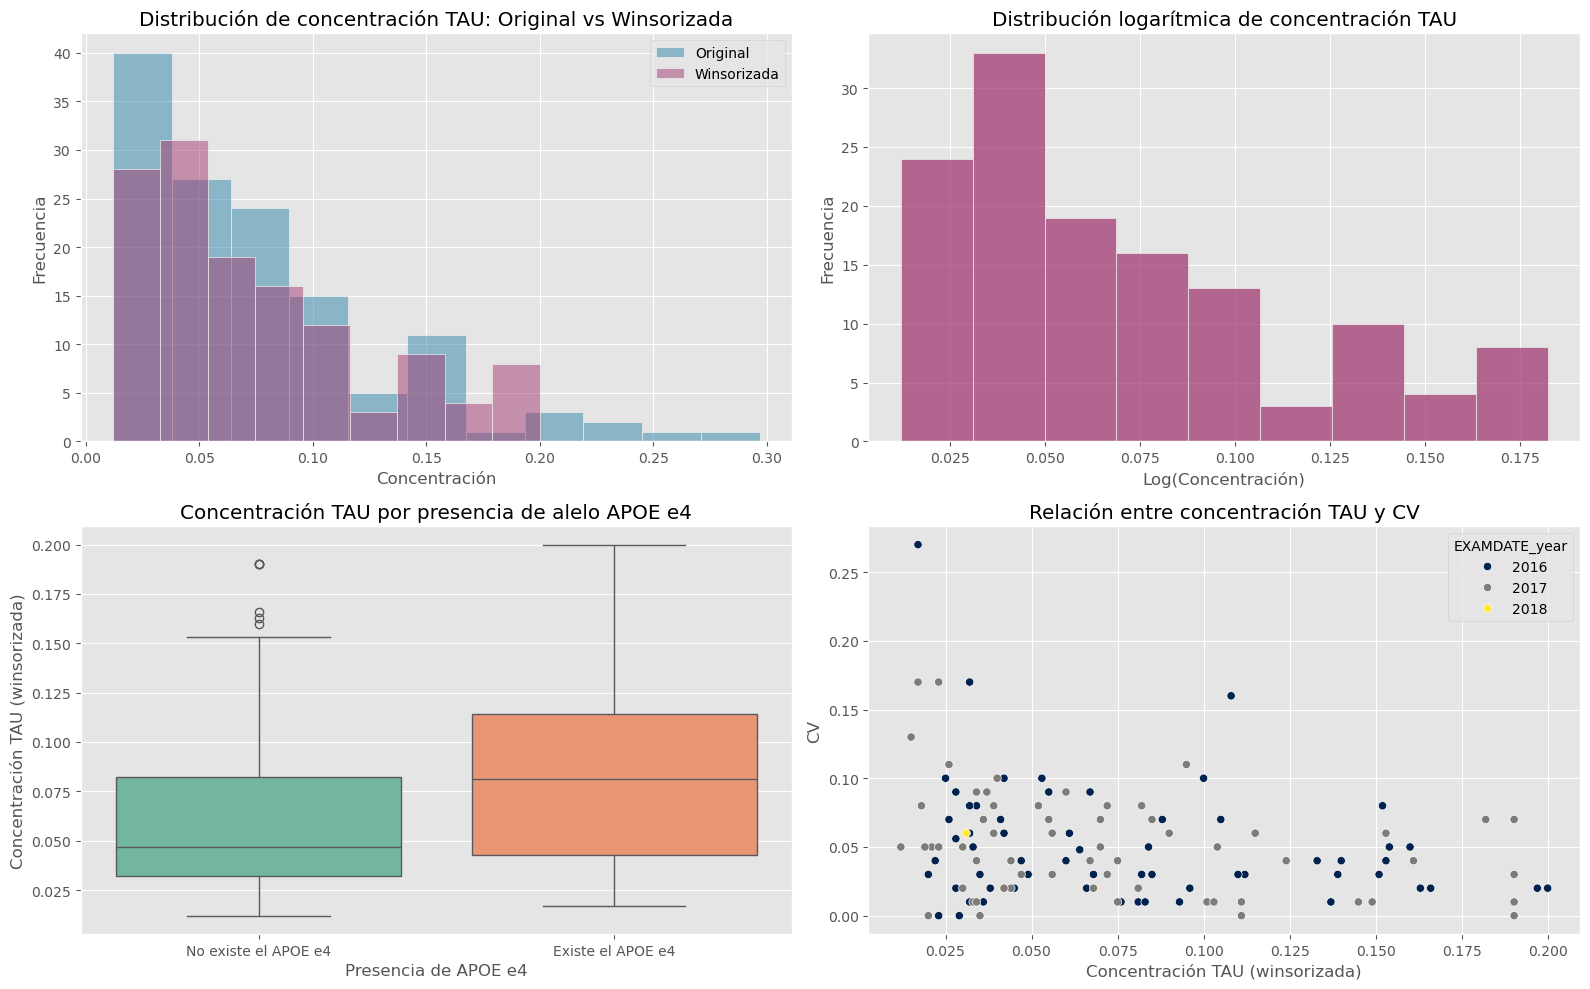

In [39]:
print("\n=== Visualización de datos procesados ===")

plt.figure(figsize=(16, 10))

# 7.1 Comparación de distribuciones original vs procesada para TAU
plt.subplot(2, 2, 1)
sns.histplot(tau_proc['DILUTION_CORRECTED_CONC_original'], color='#2E86AB', alpha=0.5, label='Original')
sns.histplot(tau_proc['DILUTION_CORRECTED_CONC_winsorized'], color='#A23B72', alpha=0.5, label='Winsorizada')
plt.title('Distribución de concentración TAU: Original vs Winsorizada')
plt.xlabel('Concentración')
plt.ylabel('Frecuencia')
plt.legend()

# 7.2 Distribución logarítmica de TAU
plt.subplot(2, 2, 2)
sns.histplot(tau_proc['DILUTION_CORRECTED_CONC_log'], color='#A23B72')
plt.title('Distribución logarítmica de concentración TAU')
plt.xlabel('Log(Concentración)')
plt.ylabel('Frecuencia')

# 7.3 Boxplot de TAU por presencia de alelo e4 (en datos fusionados)
plt.subplot(2, 2, 3)
subset = merged_data[merged_data['GENOTYPE'].notna() & merged_data['DILUTION_CORRECTED_CONC_winsorized'].notna()]
sns.boxplot(x='APOE_e4_present', y='DILUTION_CORRECTED_CONC_winsorized', data=subset, palette='Set2')
#
plt.xticks([0, 1], ['No existe el APOE e4', 'Existe el APOE e4'])
plt.title('Concentración TAU por presencia de alelo APOE e4')
plt.xlabel('Presencia de APOE e4')
plt.ylabel('Concentración TAU (winsorizada)')

# 7.4 Scatter plot de TAU vs CV tras preprocesamiento
plt.subplot(2, 2, 4)
sns.scatterplot(
    x='DILUTION_CORRECTED_CONC_winsorized', 
    y='CV', 
    hue='EXAMDATE_year',
    data=tau_proc[tau_proc['CV'].notna() & tau_proc['DILUTION_CORRECTED_CONC_winsorized'].notna()],
    palette='cividis'
)
plt.title('Relación entre concentración TAU y CV')
plt.xlabel('Concentración TAU (winsorizada)')
plt.ylabel('CV')

plt.tight_layout()
plt.savefig('../reports/figures/preprocesamiento_genetico_visualizaciones.png', dpi=300)
plt.show()

## 8. Análisis final y correlaciones

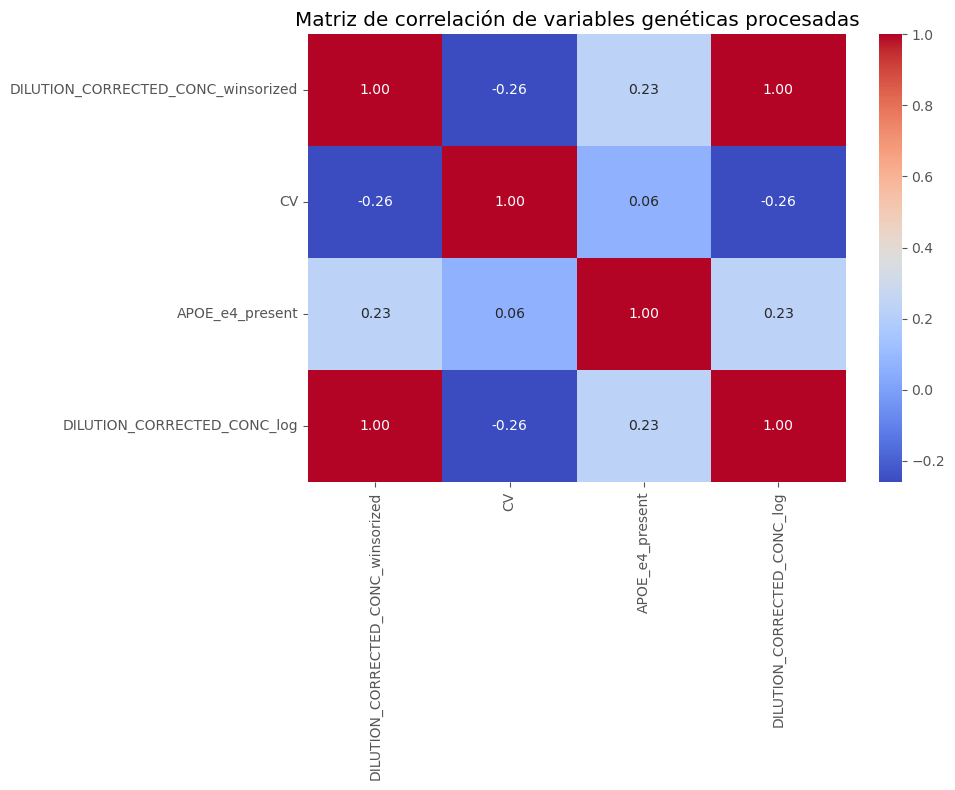


Estadísticas descriptivas de variables APOE procesadas:


,count,unique,top,freq,mean,min,25%,50%,75%,max,std
PHASE,2760,5,ADNI1,1159,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PTID,2760,2760,011_S_0002,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RID,2760.0,NaN,NaN,NaN,3382.408333,2.0,861.75,4161.0,6005.5,10194.0,2532.404542
VISCODE,1159,2,sc,822,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GENOTYPE,2760,6,3/3,1307,NaN,NaN,NaN,NaN,NaN,NaN,NaN
APTESTDT,1159,NaN,NaN,NaN,2006-07-22 12:14:17.290767872,2005-08-22 00:00:00,2006-04-03 00:00:00,2006-07-10 00:00:00,2006-11-13 00:00:00,2007-09-17 00:00:00,NaN
APVOLUME,2760.0,NaN,NaN,NaN,8.784094,1.0,9.0,9.0,9.0,10.0,1.06096
APRECEIVE,2760.0,NaN,NaN,NaN,0.967754,0.0,1.0,1.0,1.0,1.0,0.176686
APAMBTEMP,2760.0,NaN,NaN,NaN,0.999638,0.0,1.0,1.0,1.0,1.0,0.019035
APRESAMP,2760.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Estadísticas descriptivas de variables TAU procesadas:


,count,unique,top,freq,mean,min,25%,50%,75%,max,std
PTID,130,121,127_S_4604,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RID,130.0,NaN,NaN,NaN,3820.984615,31.0,4127.75,4488.5,4774.5,5263.0,1528.940881
EXAMDATE,130,NaN,NaN,NaN,2016-11-24 07:12:00,2016-01-06 00:00:00,2016-03-31 12:00:00,2016-11-16 00:00:00,2017-06-27 00:00:00,2018-01-22 00:00:00,NaN
VISCODE2,130,12,m48,63,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RUN,130.0,NaN,NaN,NaN,2.615385,1.0,2.0,3.0,4.0,5.0,1.216072
SAMPLE_ID,130,130,GA80GN4N-09,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DILUTION_CORRECTED_CONC,130.0,NaN,NaN,NaN,0.076523,0.012,0.034,0.06,0.1025,0.297,0.056024
CV,130.0,NaN,NaN,NaN,0.050569,0.0,0.02,0.04,0.07,0.27,0.040815
update_stamp,130,1,2024-01-25 20:11:34.0,130,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EXAMDATE_year,130.0,NaN,NaN,NaN,2016.484615,2016.0,2016.0,2016.0,2017.0,2018.0,0.516917


In [26]:
# 8.1 Correlación entre variables numéricas en datos fusionados
numerical_cols_merged = [
    'DILUTION_CORRECTED_CONC_winsorized', 'CV', 
    'APOE_e4_present', 'DILUTION_CORRECTED_CONC_log'
]

subset_numerical = merged_data[numerical_cols_merged].copy()
corr_matrix = subset_numerical.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de correlación de variables genéticas procesadas')
plt.tight_layout()
plt.savefig('../reports/figures/preprocesamiento_genetico_correlaciones.png', dpi=300)
plt.show()

# 8.2 Estadísticas descriptivas de variables procesadas
stats_apoe = apoe_proc.describe(include='all').T
stats_tau = tau_proc.describe(include='all').T

print("\nEstadísticas descriptivas de variables APOE procesadas:")
display(stats_apoe)

print("\nEstadísticas descriptivas de variables TAU procesadas:")
display(stats_tau)

De esta matriz de correlación se desprende que existe una fuerte correlación positiva entre las columnas ´DILUTION_CORRECTED_CONC_original´ y ´DILUTION_CORRECTED_CONC_winsorized´

## 9. Guardar datos procesados

In [40]:
# Crear dirección para guardar datos procesados
processed_dir = '../data/processed/'
interim_dir = '../data/interim/'

# Guardar datasets procesados
apoe_proc.to_csv(f'{interim_dir}APOE_processed.csv', index=False)
tau_proc.to_csv(f'{interim_dir}TAU_processed.csv', index=False)
merged_data.to_csv(f'{processed_dir}GENETIC_merged_processed.csv', index=False)

print("\n=== Datos guardados correctamente ===")
print(f"- APOE procesado: {interim_dir}APOE_processed.csv")
print(f"- TAU procesado: {interim_dir}TAU_processed.csv")
print("="*100)
print(f"- Datos genéticos fusionados: {processed_dir}GENETIC_merged_processed.csv")



=== Datos guardados correctamente ===
- APOE procesado: ../data/interim/APOE_processed.csv
- TAU procesado: ../data/interim/TAU_processed.csv
- Datos genéticos fusionados: ../data/processed/GENETIC_merged_processed.csv


## 10. Resumen de transformaciones y procesamiento

In [41]:
print("\n=== Resumen del procesamiento realizado ===")

print("""
1. Preprocesamiento de datos APOE:
   - Conversión de fechas a formato datetime y extracción de características temporales
   - Imputación de valores faltantes en variables categóricas usando la moda
   - Imputación de valores faltantes en variables numéricas usando la mediana
   - Creación de variables dummy para genotipos APOE
   - Adición de variable flag para presencia del alelo e4

2. Preprocesamiento de datos TAU:
   - Conversión de fechas a formato datetime y extracción de características temporales
   - Detección y tratamiento de valores atípicos (outliers) en concentraciones TAU mediante winsorización
   - Transformación logarítmica para normalizar la distribución de concentraciones TAU
   - Imputación de valores faltantes en CV usando KNN
   - Normalización de variables numéricas usando Min-Max scaling

3. Integración de datos:
   - Fusión de datasets APOE y TAU por identificadores de pacientes (RID)
   - Análisis de completitud y solapamiento entre datasets
   - Generación de visualizaciones para validar el preprocesamiento
   - Análisis de correlaciones entre variables genéticas procesadas

4. Resultados finales:
   - Datasets individuales procesados: APOE_processed.csv y TAU_processed.csv
   - Dataset integrado: GENETIC_merged_processed.csv
   - Visualizaciones guardadas en el directorio reports/figures/
""")

print("\nPreprocesamiento de datos genéticos completado con éxito.")


=== Resumen del procesamiento realizado ===

1. Preprocesamiento de datos APOE:
   - Conversión de fechas a formato datetime y extracción de características temporales
   - Imputación de valores faltantes en variables categóricas usando la moda
   - Imputación de valores faltantes en variables numéricas usando la mediana
   - Creación de variables dummy para genotipos APOE
   - Adición de variable flag para presencia del alelo e4

2. Preprocesamiento de datos TAU:
   - Conversión de fechas a formato datetime y extracción de características temporales
   - Detección y tratamiento de valores atípicos (outliers) en concentraciones TAU mediante winsorización
   - Transformación logarítmica para normalizar la distribución de concentraciones TAU
   - Imputación de valores faltantes en CV usando KNN
   - Normalización de variables numéricas usando Min-Max scaling

3. Integración de datos:
   - Fusión de datasets APOE y TAU por identificadores de pacientes (RID)
   - Análisis de completitud y

##

***

__Abraham Tartalos__